In [ ]:
pip install scikit-plot

## load libraries and the Drive

In [ ]:
import glob, os.path
import numpy as np
import pandas as pd
import tensorflow as tf
import cv2
from tensorflow.keras.models import Model
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense,Dropout
from tensorflow.keras.layers import Lambda, Layer, ReLU
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.layers.normalization import BatchNormalization
from tensorflow import keras
from tensorflow.keras.callbacks import LearningRateScheduler
from keras.models import load_model
import matplotlib.pyplot as plt
from keras.preprocessing.image import load_img, img_to_array
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
from sklearn import svm, datasets
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
import pandas as pd
import seaborn as sn
from sklearn.metrics import roc_curve,roc_auc_score
import seaborn as sns
from sklearn.model_selection import train_test_split

In [ ]:
from google.colab import drive
drive.mount('/content/Drive')  # importar datos desde el drive

Drive already mounted at /content/Drive; to attempt to forcibly remount, call drive.mount("/content/Drive", force_remount=True).


In [ ]:
import sys
sys.path.append('/content/drive')

## Load Data

In [ ]:
data_entrenamiento = '/content/Drive/My Drive/HAM10000/Base de Datos_Clasificada y Aumentada(7_Clases)/Train_final'
data_validacion = '/content/Drive/My Drive/HAM10000/Base de Datos_Clasificada y Aumentada(7_Clases)/Validation'
data_text = '/content/Drive/My Drive/HAM10000/Base de Datos_Clasificada y Aumentada(7_Clases)/Text'

## Graphics card provided by Google Colab

In [ ]:
!nvidia-smi

Sat Jan 16 22:01:18 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.27.04    Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   77C    P0    35W /  70W |  14577MiB / 15079MiB |      0%      Default |
|                               |                      |                 ERR! |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

## Load Model InceptionResNetV2

In [ ]:

pre_trained_model = tf.keras.applications.InceptionResNetV2(
                    include_top=False,
                    weights='imagenet',
                    input_shape = (224, 224, 3)
                    )

In [ ]:
pre_trained_model.summary()

Model: "inception_resnet_v2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv2d_203 (Conv2D)             (None, 111, 111, 32) 864         input_3[0][0]                    
__________________________________________________________________________________________________
batch_normalization_207 (BatchN (None, 111, 111, 32) 96          conv2d_203[0][0]                 
__________________________________________________________________________________________________
activation_203 (Activation)     (None, 111, 111, 32) 0           batch_normalization_207[0][0]    
________________________________________________________________________________

In [ ]:

for i, layer in enumerate(pre_trained_model.layers):
   print(i, layer.name)

0 input_3
1 conv2d_203
2 batch_normalization_207
3 activation_203
4 conv2d_204
5 batch_normalization_208
6 activation_204
7 conv2d_205
8 batch_normalization_209
9 activation_205
10 max_pooling2d_4
11 conv2d_206
12 batch_normalization_210
13 activation_206
14 conv2d_207
15 batch_normalization_211
16 activation_207
17 max_pooling2d_5
18 conv2d_211
19 batch_normalization_215
20 activation_211
21 conv2d_209
22 conv2d_212
23 batch_normalization_213
24 batch_normalization_216
25 activation_209
26 activation_212
27 average_pooling2d_1
28 conv2d_208
29 conv2d_210
30 conv2d_213
31 conv2d_214
32 batch_normalization_212
33 batch_normalization_214
34 batch_normalization_217
35 batch_normalization_218
36 activation_208
37 activation_210
38 activation_213
39 activation_214
40 mixed_5b
41 conv2d_218
42 batch_normalization_222
43 activation_218
44 conv2d_216
45 conv2d_219
46 batch_normalization_220
47 batch_normalization_223
48 activation_216
49 activation_219
50 conv2d_215
51 conv2d_217
52 conv2d_220

In [ ]:
for layer in pre_trained_model.layers[:180]: #400
   layer.trainable = False
for layer in pre_trained_model.layers[180:]:
   layer.trainable = True

In [ ]:

train_datagen = ImageDataGenerator( rescale = 1.0/255 )  # images normalization
validation_datagen  = ImageDataGenerator( rescale = 1.0/255. )
test_datagen  = ImageDataGenerator( rescale = 1.0/255. )


train_generator = train_datagen.flow_from_directory(data_entrenamiento,
                                                    batch_size=64,
                                                    class_mode='categorical',
                                                    color_mode="rgb",
                                                    target_size=(224, 224),
                                                    )     

validation_generator =  validation_datagen.flow_from_directory(data_validacion,
                                                         batch_size=64,
                                                         class_mode  = 'categorical',
                                                         color_mode="rgb",
                                                         target_size = (224, 224))


test_generator =  test_datagen.flow_from_directory(data_text,
                                                         batch_size=64,
                                                         color_mode="rgb",
                                                         class_mode  = 'categorical',
                                                         target_size = (224, 224))



Found 32201 images belonging to 7 classes.
Found 7150 images belonging to 7 classes.
Found 3574 images belonging to 7 classes.


## Hidden Layer Design

In [ ]:
def model_new():
  inputs = tf.keras.Input(shape=(224, 224, 3))

  x = pre_trained_model(inputs)

  layers = tf.keras.layers.GlobalAveragePooling2D()(x)
  #layers = Flatten(name="flatten")(pre_trained_model)

  #Hidden Layers
  layers = Dense(512)(layers)
  layers = BatchNormalization()(layers)
  layers = ReLU()(layers)

  layers = Dense(128)(layers)
  layers = BatchNormalization()(layers)
  layers = ReLU()(layers)


  layers = Dense(64)(layers)
  layers = BatchNormalization()(layers)
  layers = ReLU()(layers)


  layers = Dense(32)(layers)
  layers = BatchNormalization()(layers)
  layers = ReLU()(layers)

  #Clasification Layer
  predictions = Dense(7, activation="softmax", name="output_1")(layers)
  model = Model(inputs = inputs, outputs=predictions)

  return model

In [ ]:
modelFT = model_new()
modelFT.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
inception_resnet_v2 (Functio (None, 5, 5, 1536)        54336736  
_________________________________________________________________
global_average_pooling2d_1 ( (None, 1536)              0         
_________________________________________________________________
dense_4 (Dense)              (None, 512)               786944    
_________________________________________________________________
batch_normalization_410 (Bat (None, 512)               2048      
_________________________________________________________________
re_lu_4 (ReLU)               (None, 512)               0         
_________________________________________________________________
dense_5 (Dense)              (None, 128)               6566

Optimizer

In [ ]:

#lr_schedule = keras.optimizers.schedules.ExponentialDecay(
#    initial_learning_rate=1e-4,
#    decay_steps=1000,
#    decay_rate=0.85)
#optimizer = keras.optimizers.Adamax(learning_rate=lr_schedule)

modelFT.compile(
    optimizer="Adamax",
    loss="categorical_crossentropy",
    metrics=["accuracy"]
    )

In [ ]:

DESIRED_ACCURACY = 0.999
INIT_LR = 1e-3
def exp_decay(epoch):
  initial_lrate = 1e-3
  k = 0.095
  lrate = initial_lrate * np.exp(-k*epoch)
  return lrate



class LossHistory(tf.keras.callbacks.Callback):
  def on_train_begin(self, logs={}):
    self.losses = []
    self.lr = []

  def on_epoch_end(self, batch, logs={}):
    self.losses.append(logs.get('loss'))
    self.lr.append(exp_decay(len(self.losses)))

class end_train(tf.keras.callbacks.Callback):
        def on_epoch_end(self,epoch,log={}):
            if log.get('val_accuracy')>DESIRED_ACCURACY:
                print("\nReached"+str(DESIRED_ACCURACY)+"% val_accuracy so cancelling training!")
                self.model.stop_training = True
end_t = end_train()
loss_history = LossHistory()
lrate = LearningRateScheduler(exp_decay)       
callbacks_list = [loss_history,lrate,end_t]

callbacks=callbacks_list

## Train Model

In [ ]:
steps_per_epoch = train_generator.n // 64
validation_steps = validation_generator.n // 64
history = modelFT.fit (train_generator,             
                         validation_data = validation_generator,             
                         steps_per_epoch = steps_per_epoch,           
                         epochs = 33,             
                         validation_steps = validation_steps,             
                         verbose = 2,
                         callbacks=callbacks
                        ) 

Epoch 1/33
503/503 - 2695s - loss: 0.6781 - accuracy: 0.7758 - val_loss: 0.5930 - val_accuracy: 0.7898
Epoch 2/33
503/503 - 496s - loss: 0.2419 - accuracy: 0.9250 - val_loss: 0.3173 - val_accuracy: 0.8958
Epoch 3/33
503/503 - 496s - loss: 0.1216 - accuracy: 0.9628 - val_loss: 0.1995 - val_accuracy: 0.9333
Epoch 4/33
503/503 - 496s - loss: 0.0793 - accuracy: 0.9778 - val_loss: 0.1765 - val_accuracy: 0.9464
Epoch 5/33
503/503 - 495s - loss: 0.0478 - accuracy: 0.9866 - val_loss: 0.2454 - val_accuracy: 0.9269
Epoch 6/33
503/503 - 495s - loss: 0.0372 - accuracy: 0.9896 - val_loss: 0.2127 - val_accuracy: 0.9417
Epoch 7/33
503/503 - 495s - loss: 0.0241 - accuracy: 0.9939 - val_loss: 0.1402 - val_accuracy: 0.9565
Epoch 8/33
503/503 - 495s - loss: 0.0136 - accuracy: 0.9966 - val_loss: 0.1225 - val_accuracy: 0.9652
Epoch 9/33
503/503 - 495s - loss: 0.0097 - accuracy: 0.9978 - val_loss: 0.1311 - val_accuracy: 0.9640
Epoch 10/33
503/503 - 495s - loss: 0.0096 - accuracy: 0.9976 - val_loss: 0.1793 -

## Save Model

In [ ]:
modelFT.save('/content/Drive/MyDrive/modelos Ham10000/modelo_inceptionResnetv2.h5')  # creates a HDF5 file 'my_model.h5'


#model = load_model('/content/Drive/My Drive/HAM10000/model_final_prueba.h5')

In [ ]:
modelFT.save('/content/Drive/My Drive/HAM10000/tmp2/model')

Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
INFO:tensorflow:Assets written to: /content/Drive/My Drive/HAM10000/tmp2/model/assets


#Results

No handles with labels found to put in legend.


<Figure size 432x288 with 0 Axes>

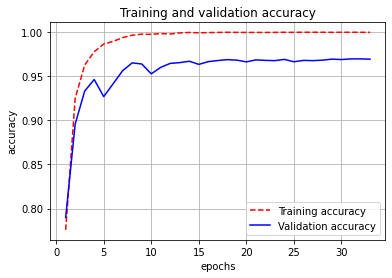

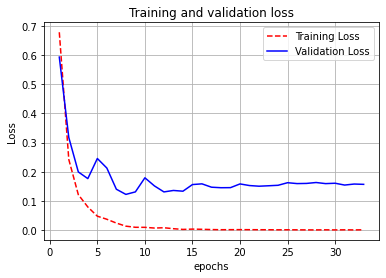

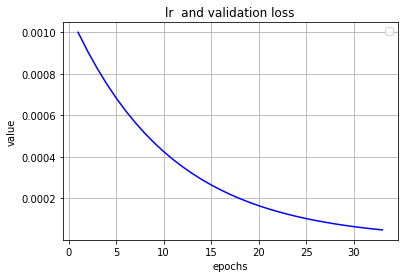

<Figure size 432x288 with 0 Axes>

In [ ]:

acc = history.history[ 'accuracy' ] # with drop
val_acc = history.history[ 'val_accuracy' ]
loss = history.history[ 'loss' ]
val_loss = history.history['val_loss' ]
lr = history.history['lr' ]
epochs = range(1,len(acc)+1,1)
plt.plot ( epochs, acc, 'r--', label='Training accuracy' )
plt.grid(True)
plt.plot ( epochs, val_acc, 'b', label='Validation accuracy')
plt.grid(True)
plt.title ('Training and validation accuracy')
plt.ylabel('accuracy')
plt.xlabel('epochs')
plt.legend()
plt.figure()
plt.plot ( epochs, loss, 'r--' , label='Training Loss' )
plt.grid(True)
plt.plot ( epochs, val_loss , 'b', label='Validation Loss'  )
plt.grid(True)
plt.title ('Training and validation loss' )
plt.ylabel('Loss')
plt.xlabel('epochs')
plt.legend()
plt.figure()
plt.plot ( epochs, loss, 'r--' )
plt.plot ( epochs, lr, 'b' )
plt.grid(True)
plt.title ('lr  and validation loss' )
plt.ylabel('value')
plt.xlabel('epochs')
plt.legend()
plt.figure()

Load Model

In [ ]:
modelFT = load_model('/content/Drive/My Drive/HAM10000/model_final_prueba.h5')

In [ ]:
test_lost, test_acc= modelFT.evaluate(test_generator)
print ("Test Accuracy:", test_acc)